# Part 4 – Model Comparison


1 - For the classification problem (you developed the estimator in Part 2) you will use all the
numerical features and predict the “cut”. The steps to implement are:

- Select 3 classifiers from the scikit-learn library (you can pick any classifier of your choice,
  including those not seen in class yet).
- For each model (your model as well as the scikit-learn ones), use the training and
  validation sets to choose the best hyperparameters.
- Combine the training and validation sets into a single set and use it to train the models
  with the chosen hyperparameters.
- Compare the performance of the different estimators using the accuracy score.
- Make a plot that shows this comparison (here you can use any type of plot you like, as
  long as the comparison is clear).


In [ ]:
# Doing everything done in part-2.ipynb

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator

diamonds_dataset = pd.read_csv("../data/diamonds.csv")

n = len(diamonds_dataset)
splits = [int(0.8 * n), int(0.9 * n)]
training, validation, testing = np.split(diamonds_dataset.sample(frac=1), splits)


class KNNClassifier(BaseEstimator):
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X, distances="euclidean"):
        n_samples = X.shape[0]
        predictions = np.empty(n_samples, dtype=object)

        if distances == "euclidean":
            for i in range(n_samples):
                point_distances = np.sum(np.square(self.X - X[i, :]), axis=1)
                idx = np.argpartition(point_distances, self.k)[: self.k]

                values, counts = np.unique(self.y[idx], return_counts=True)

                predictions[i] = values[np.argmax(counts)]
        else:
            for i in range(n_samples):
                point_distances = self.distances[i, :]
                idx = np.argpartition(point_distances, self.k)[: self.k]

                values, counts = np.unique(self.y[idx], return_counts=True)

                predictions[i] = values[np.argmax(counts)]

        return predictions


In [5]:
# Importing 3 classifiers from sciki-learn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [30]:
# Testing the hyperparameters

from sklearn.metrics import accuracy_score

features = ["carat", "depth", "table", "price", "x", "y", "z"]
target = "cut"

estimators = []

X_train, y_train = training[features].to_numpy(), training[target].to_numpy()
X_validation, y_validation = (
    validation[features].to_numpy()[:500],
    validation[target].to_numpy()[:500],
)

for k in [2, 10, 50, 100]:
    estimator = KNNClassifier(k=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    accuracy = accuracy_score(y_validation, predictions)
    estimators.append(("KNNClassifier", k, accuracy))

    print(f"KNNClassifier(k={k}): {accuracy:.2f}%")

for k in [2, 10, 50, 100]:
    estimator = KNeighborsClassifier(n_neighbors=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    accuracy = accuracy_score(y_validation, predictions)
    estimators.append(("KNeighborsClassifier", k, accuracy))

    print(f"KNeighborsClassifier(n_neighbors={k}): {accuracy:.2f}%")

for k in [2, 10, 50, 100]:
    estimator = DecisionTreeClassifier(max_depth=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    accuracy = accuracy_score(y_validation, predictions)
    estimators.append(("DecisionTreeClassifier", k, accuracy))

    print(f"DecisionTreeClassifier(max_depth={k}): {accuracy:.2f}%")

for k in [2, 10, 50, 100]:
    estimator = RandomForestClassifier(n_estimators=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    accuracy = accuracy_score(y_validation, predictions)
    estimators.append(("RandomForestClassifier", k, accuracy))

    print(f"RandomForestClassifier(n_estimators={k}): {accuracy:.2f}%")


KNNClassifier(k=2): 0.59%
KNNClassifier(k=10): 0.55%
KNNClassifier(k=50): 0.48%
KNNClassifier(k=100): 0.45%
KNeighborsClassifier(n_neighbors=2): 0.59%
KNeighborsClassifier(n_neighbors=10): 0.55%
KNeighborsClassifier(n_neighbors=50): 0.48%
KNeighborsClassifier(n_neighbors=100): 0.45%
DecisionTreeClassifier(max_depth=2): 0.67%
DecisionTreeClassifier(max_depth=10): 0.74%
DecisionTreeClassifier(max_depth=50): 0.70%
DecisionTreeClassifier(max_depth=100): 0.71%
RandomForestClassifier(n_estimators=2): 0.71%
RandomForestClassifier(n_estimators=10): 0.74%
RandomForestClassifier(n_estimators=50): 0.79%
RandomForestClassifier(n_estimators=100): 0.78%


In [40]:
# Selecting the best estimators

best_estimators = {}

for name, k, accuracy in estimators:
    estimator = None

    match name:
        case "KNNClassifier":
            estimator = KNNClassifier(k=k)
        case "KNeighborsClassifier":
            estimator = KNeighborsClassifier(n_neighbors=k)
        case "DecisionTreeClassifier":
            estimator = DecisionTreeClassifier(max_depth=k)
        case "RandomForestClassifier":
            estimator = RandomForestClassifier(n_estimators=k)

    if name not in best_estimators:
        best_estimators[name] = (estimator, accuracy)

    if accuracy > best_estimators[name][1]:
        best_estimators[name] = (estimator, accuracy)

best_estimators


{'KNNClassifier': (KNNClassifier(k=2), 0.594),
 'KNeighborsClassifier': (KNeighborsClassifier(n_neighbors=2), 0.594),
 'DecisionTreeClassifier': (DecisionTreeClassifier(max_depth=10), 0.744),
 'RandomForestClassifier': (RandomForestClassifier(n_estimators=50), 0.786)}

In [41]:
# Getting the final accuracies

accuracies = pd.DataFrame(columns=["estimator", "accuracy"])

X = np.concatenate((X_train, X_validation))
y = np.concatenate((y_train, y_validation))

X_test = testing[features].to_numpy()
y_test = testing[target].to_numpy()

for name, (estimator, _) in best_estimators.items():
    estimator.fit(X, y)
    predictions = estimator.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)

    accuracies = pd.concat(
        [accuracies, pd.DataFrame({"estimator": [name], "accuracy": [accuracy]})],
        axis=0,
        ignore_index=True,
    )

accuracies


,estimator,accuracy
0,KNNClassifier,0.557286
1,KNeighborsClassifier,0.557286
2,DecisionTreeClassifier,0.742677
3,RandomForestClassifier,0.772525


<AxesSubplot:xlabel='estimator', ylabel='accuracy'>

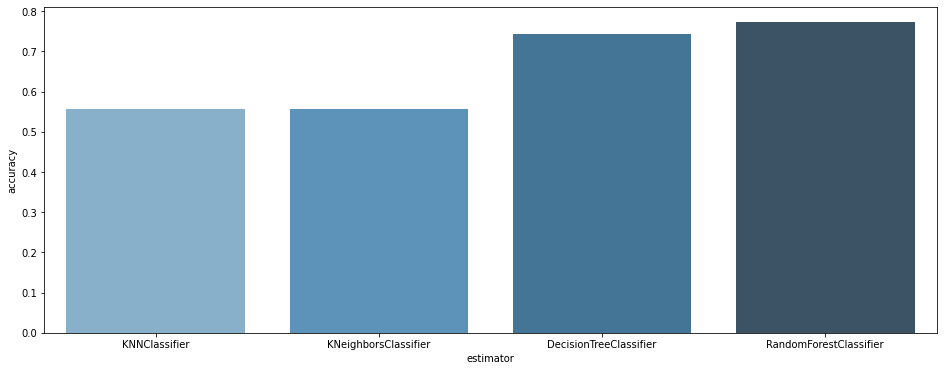

In [46]:
# Plotting the accuracies

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(data=accuracies, x="estimator", y="accuracy", palette="Blues_d", ax=ax)


2 - For the regression problem (you developed the estimator in Part 2) you will predict the "price" using the remaining numerical features. The steps to implement are:
- Select 3 regressors from the scikit-learn library (you can pick any regressor of your
choice, including those not seen in class yet).
- For each model (your model as well as the scikit-learn ones), use the training and
validation sets to choose the best hyperparameters.
- Combine the training and validation sets into a single set and use it to train the models
with the chosen hyperparameters.
- Compare the performance of the different estimators using the Root Mean Square Error
score.
- Make a plot that shows this comparison (here you can use any type of plot you like, as
long as the comparison is clear).

In [1]:
# Doing everything done in part-3.ipynb

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator

diamonds_dataset = pd.read_csv("../data/diamonds.csv")

n = len(diamonds_dataset)
splits = [int(0.8 * n), int(0.9 * n)]
training, validation, testing = np.split(diamonds_dataset.sample(frac=1), splits)


class LinearRegression(BaseEstimator):
    def __init__(
        self, solver: str = "sgd", max_iter: int = 100, learning_rate: float = 0.0001
    ):
        self.solver = solver
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    def _fit_cf(self, X: np.ndarray, y: np.ndarray):
        n = X.shape[0]
        regularization_term = np.sqrt(np.sum(np.square(X)) / n)

        lambda_I = np.eye(X.shape[1]) * regularization_term
        w = np.linalg.inv(X.T @ X + lambda_I) @ X.T @ y

        return w

    def _fit_sgd(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape
        w = np.zeros(n_features)

        for i in range(self.max_iter):
            for j in range(n_samples):
                gradient = (y[j] - w @ X[j]) * X[j]
                w += self.learning_rate * gradient

        return w

    def fit(self, X: np.ndarray, y: np.ndarray):
        n = X.shape[0]
        X_ = np.c_[np.ones(n), X]

        if self.solver == "cf":
            self.w = self._fit_cf(X_, y)
        elif self.solver == "sgd":
            self.w = self._fit_sgd(X_, y)
        else:
            raise ValueError("Solver not implemented")

    def predict(self, X):
        X_ = np.c_[np.ones(len(X)), X]
        return X_ @ self.w



In [2]:
# Importing 3 regressors from scikit-learn

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor


In [4]:
# Testing the hyperparameters

from sklearn.metrics import mean_squared_error


def rmse(y_true: np.ndarray, y_pred: np.ndarray):
    return mean_squared_error(y_true, y_pred, squared=False)


features = ["carat", "depth", "table", "x", "y", "z"]
target = "price"

estimators = []

X_train, y_train = training[features].to_numpy(), training[target].to_numpy()
X_validation, y_validation = (
    validation[features].to_numpy()[:500],
    validation[target].to_numpy()[:500],
)

for k in [2, 10, 50, 100]:
    estimator = LinearRegression(solver="sgd", max_iter=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    error = rmse(y_validation, predictions)
    estimators.append(("LinearRegression", k, error))

    print(f"LinearRegression(max_iter={k}): {error:.2f}")

for k in [2, 10, 50, 100, 500]:
    estimator = DecisionTreeRegressor(min_samples_leaf=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    error = rmse(y_validation, predictions)
    estimators.append(("DecisionTreeRegressor", k, error))

    print(f"DecisionTreeRegressor(min_samples_leaf={k}): {error:.2f}")

for k in [2, 100, 500, 2000, 5000]:
    estimator = LinearSVR(epsilon=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    error = rmse(y_validation, predictions)
    estimators.append(("LinearSVR", k, error))

    print(f"LinearSVR(epsilon={k}): {error:.2f}")

for k in [2, 10, 50, 100, 500]:
    estimator = GradientBoostingRegressor(n_estimators=k)
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_validation)

    error = rmse(y_validation, predictions)
    estimators.append(("GradientBoostingRegressor", k, error))

    print(f"GradientBoostingRegressor(n_estimators={k}): {error:.2f}")


LinearRegression(max_iter=2): 2063.43
LinearRegression(max_iter=10): 1833.52
LinearRegression(max_iter=50): 1581.56
LinearRegression(max_iter=100): 1562.44
DecisionTreeRegressor(min_samples_leaf=2): 1798.42
DecisionTreeRegressor(min_samples_leaf=10): 1507.94
DecisionTreeRegressor(min_samples_leaf=50): 1335.14
DecisionTreeRegressor(min_samples_leaf=100): 1377.58
DecisionTreeRegressor(min_samples_leaf=500): 1380.07
LinearSVR(epsilon=2): 1976.99
LinearSVR(epsilon=100): 1974.07
LinearSVR(epsilon=500): 1907.48
LinearSVR(epsilon=2000): 1796.88
LinearSVR(epsilon=5000): 3572.73
GradientBoostingRegressor(n_estimators=2): 3377.02
GradientBoostingRegressor(n_estimators=10): 1923.07
GradientBoostingRegressor(n_estimators=50): 1334.65
GradientBoostingRegressor(n_estimators=100): 1315.90
GradientBoostingRegressor(n_estimators=500): 1322.82


In [5]:
# Selecting the best estimators

best_estimators = {}

for name, k, error in estimators:
    estimator = None

    match name:
        case "LinearRegression":
            estimator = LinearRegression(solver="sgd", max_iter=k)
        case "DecisionTreeRegressor":
            estimator = DecisionTreeRegressor(min_samples_leaf=k)
        case "LinearSVR":
            estimator = LinearSVR(epsilon=k)
        case "GradientBoostingRegressor":
            estimator = GradientBoostingRegressor(n_estimators=k)

    if name not in best_estimators:
        best_estimators[name] = (estimator, error)

    if error < best_estimators[name][1]:
        best_estimators[name] = (estimator, error)

best_estimators


{'LinearRegression': (LinearRegression(), 1562.4387418037095),
 'DecisionTreeRegressor': (DecisionTreeRegressor(min_samples_leaf=50),
  1335.1430831919909),
 'LinearSVR': (LinearSVR(epsilon=2000), 1796.8837323138614),
 'GradientBoostingRegressor': (GradientBoostingRegressor(),
  1315.8974813097889)}

In [6]:
# Getting the final errors

errors = pd.DataFrame(columns=["estimator", "error"])

X = np.concatenate((X_train, X_validation))
y = np.concatenate((y_train, y_validation))

X_test = testing[features].to_numpy()
y_test = testing[target].to_numpy()

for name, (estimator, _) in best_estimators.items():
    estimator.fit(X, y)
    predictions = estimator.predict(X_test)

    error = rmse(y_test, predictions)

    errors = pd.concat(
        [errors, pd.DataFrame({"estimator": [name], "error": [error]})],
        axis=0,
        ignore_index=True,
    )

errors


,estimator,error
0,LinearRegression,1516.279192
1,DecisionTreeRegressor,1361.087842
2,LinearSVR,1783.632612
3,GradientBoostingRegressor,1322.456299


<AxesSubplot:xlabel='estimator', ylabel='error'>

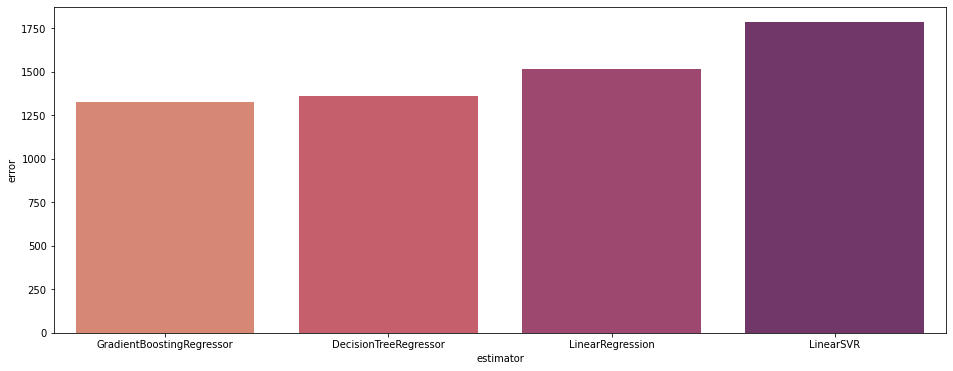

In [7]:
# Plotting the accuracies

import seaborn as sns
import matplotlib.pyplot as plt

data = errors.sort_values(by="error")
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(data=data, x="estimator", y="error", palette="flare", ax=ax)
